This example notebook shows how to use `rasterio` to align two spatially overlapping rasters.

Here we have two rasters: aerial imagery at a 1m spatial resolution for a part of Redmond, WA and a US-wide land cover raster at a 30m spatial resolution. We would like to do a few things to the land cover raster so that we can easily use it in a machine learning pipeline with the aerial iamgery:
1. We would like to crop out the land cover data for _just_ the area covered by the aerial imagery
2. We would like to reproject the land cover data into the same coordinate system used by the aerial imagery
3. We would like to resample the land cover data to the same spatial resolution of the aerial imagery

If we can do these three things, then we will have two raster layers that are aligned at the pixel level, and that can be trivially used in a variety of ML workflows (e.g. we could try to train a model to super resolve the land cover data given the aerial imagery). `rasterio` makes it very easy to do all three of these in-memory with a `WarpedVRT`, see below!

In [1]:
%matplotlib inline
import os
# Some best practice environmental variables to use when working with COGs -- https://github.com/pangeo-data/cog-best-practices
env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
           AWS_NO_SIGN_REQUEST='YES',
           GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
           GDAL_SWATH_SIZE='200000000',
           VSI_CURL_CACHE_SIZE='200000000')
os.environ.update(env)

import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt

import affine
import rasterio
import rasterio.enums
import rasterio.vrt

In [2]:
# NAIP COG for Redmond, WA
naip_url = 'https://naipblobs.blob.core.windows.net/naip/v002/wa/2017/wa_100cm_2017/47122/m_4712224_sw_10_1_20170815.tif'

# NLCD data for CONUS 2016 in COG format 
nlcd_url = 'https://cpdataeuwest.blob.core.windows.net/cpdata/raw/nlcd/conus/30m/2016.tif'

In [3]:
%%time

with rasterio.open(naip_url) as f:
    naip_left = f.bounds.left
    naip_top = f.bounds.top
    naip_height = f.height
    naip_width = f.width
    naip_crs = f.crs.to_string()
    naip_data = np.rollaxis(f.read(), 0, 3)

print(naip_data.shape)

(7628, 5402, 4)
CPU times: user 1.31 s, sys: 342 ms, total: 1.66 s
Wall time: 4.41 s


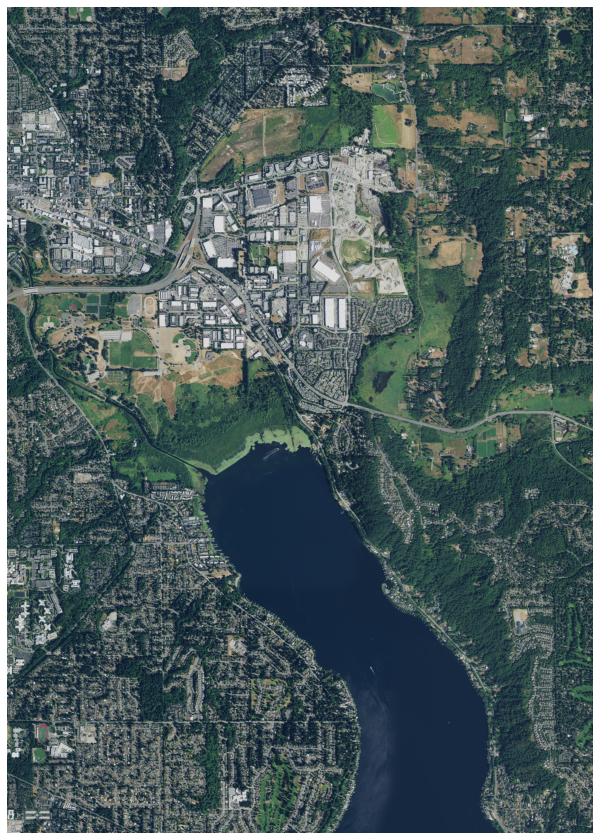

In [4]:
plt.figure(figsize=(5.4*2, 7.6*2))
plt.imshow(naip_data[:,:,:3])
plt.axis("off")
plt.show()
plt.close()

In [5]:
%%time
with rasterio.open(nlcd_url) as src:
    xres = 1.0 # meters
    yres = 1.0 # meters
    dst_transform = affine.Affine(xres, 0.0, naip_left, 0.0, -yres, naip_top)

    vrt_options = {
        'resampling': rasterio.enums.Resampling.nearest,
        'crs': naip_crs,
        'transform': dst_transform,
        'height': naip_height,
        'width': naip_width,
    }

    with rasterio.vrt.WarpedVRT(src, **vrt_options) as vrt:
        nlcd_data = vrt.read().squeeze()
print(nlcd_data.shape)

(7628, 5402)
CPU times: user 834 ms, sys: 44.5 ms, total: 879 ms
Wall time: 2.39 s


In [6]:
# NLCD class colormap
NLCD_CLASS_COLORS = {
    0:  (0, 0, 0, 0),
    11: (70, 107, 159, 255),
    12: (209, 222, 248, 255),
    21: (222, 197, 197, 255),
    22: (217, 146, 130, 255),
    23: (235, 0, 0, 255),
    24: (171, 0, 0, 255),
    31: (179, 172, 159, 255),
    41: (104, 171, 95, 255),
    42: (28, 95, 44, 255),
    43: (181, 197, 143, 255),
    52: (204, 184, 121, 255),
    71: (223, 223, 194, 255),
    81: (220, 217, 57, 255),
    82: (171, 108, 40, 255),
    90: (184, 217, 235, 255),
    95: (108, 159, 184, 255)
}

colors = []
for i in range(256):
    if i in NLCD_CLASS_COLORS:
        r,g,b,a = NLCD_CLASS_COLORS[i]
        colors.append((r/255.0, g/255.0, b/255.0, a/255.0))
    else:
        colors.append((0,0,0,0))
cmap = matplotlib.colors.ListedColormap(colors)

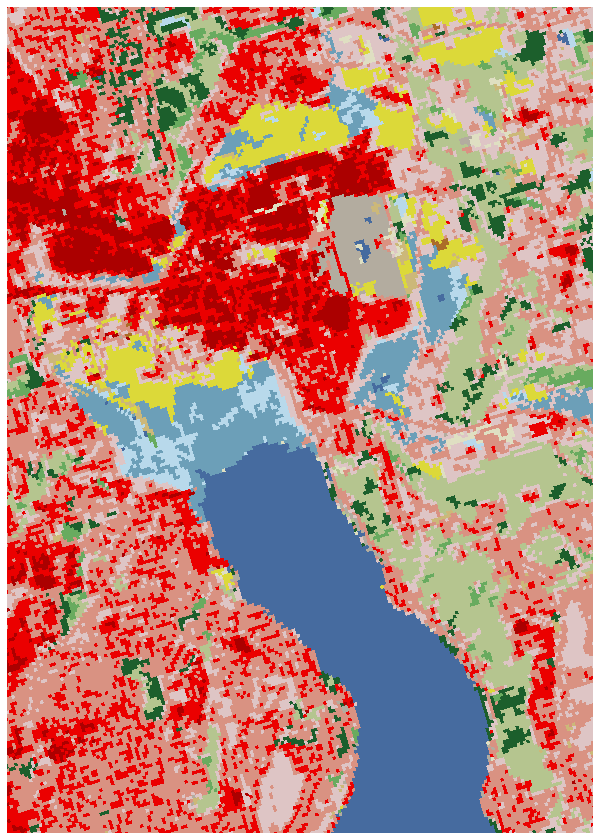

In [7]:
plt.figure(figsize=(5.4*2, 7.6*2))
plt.imshow(nlcd_data, cmap=cmap, vmin=0, vmax=256, interpolation="none")
plt.axis("off")
plt.show()
plt.close()

In [8]:
# For every pixel of NAIP data we have a matching pixel of NLCD data
assert naip_data.shape[0] == nlcd_data.shape[0] and naip_data.shape[1] == nlcd_data.shape[1]